In [1]:
import torch
import torchaudio
from codec.audio import load_mono_audio, spectogram, resampler
from codec.model import FACodec
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from resemble_enhance.enhancer.inference import enhance

[2024-03-18 05:27:47,869] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
def do_spectogram(src):
    return spectogram(src, 1024, 120, 200, 800, "slaney", "slaney", 16000)

def improve_audio(src):
    res, new_sr = enhance(src.cpu(), 16000, "cpu", nfe=24, solver="midpoint", lambd=0.1, tau=0.5)
    res = resampler(new_sr, 16000)(res)
    return res

def plot_debug(waveform):

    # Preprocess
    spec = do_spectogram(waveform)

    # Display audio
    display(Audio(data=waveform.cpu(), rate=16000))
    # display(Audio(data=waveform_post, rate=config.audio.sample_rate))

    # Pitch detector
    # f0, t0 = pw.dio(waveform.cpu().squeeze(0).numpy().astype('double'), config.audio.sample_rate, frame_period=(1000 * config.audio.hop_size)/config.audio.sample_rate)
    # f0 = 2595 * torch.log10(1 + torch.tensor(f0) / 700)
    # f0 = f0 / (2595 * torch.log10(torch.tensor(1 + 24000 / 700))) * (100 - 1)

    # Plot
    _, axis = plt.subplots(1, 1, figsize=(20, 5))
    axis.imshow(spec.cpu(), cmap="viridis", vmin=-10, vmax=0, origin="lower", aspect="auto")
    # axis.plot(f0, color="white")
    # axis.set_title(title)
    plt.tight_layout()

In [3]:
model = FACodec()
encoder_checkpoint = torch.load(f'./source_checkpoints/ns3_facodec_encoder.bin', map_location="cpu")
decoder_checkpoint = torch.load(f'./source_checkpoints/ns3_facodec_decoder.bin', map_location="cpu")
redecoder_checkpoint = torch.load(f'./source_checkpoints/ns3_facodec_redecoder.bin', map_location="cpu")
model.encoder.load_state_dict(encoder_checkpoint)
model.decoder.load_state_dict(decoder_checkpoint)
model.redecoder.load_state_dict(redecoder_checkpoint)
model.eval()

/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


FACodec(
  (encoder): FACodecEncoder(
    (block): Sequential(
      (0): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): EncoderBlock(
        (block): Sequential(
          (0): ResidualUnit(
            (block): Sequential(
              (0): Activation1d(
                (act): SnakeBeta()
                (upsample): UpSample1d()
                (downsample): DownSample1d(
                  (lowpass): LowPassFilter1d()
                )
              )
              (1): Conv1d(32, 32, kernel_size=(7,), stride=(1,), padding=(3,))
              (2): Activation1d(
                (act): SnakeBeta()
                (upsample): UpSample1d()
                (downsample): DownSample1d(
                  (lowpass): LowPassFilter1d()
                )
              )
              (3): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
            )
          )
          (1): ResidualUnit(
            (block): Sequential(
              (0): Activation1d(
                (a

In [4]:
source = load_mono_audio("./eval/eval_3_normal.wav", 16000)
source_enchanced = improve_audio(source)
source_style = load_mono_audio("./eval/eval_3_surprise.wav", 16000)

Already up to date.


In [5]:
prosody_code, cotent_code, residual_code, spk_embs = model.encode(source)
e_prosody_code, e_cotent_code, e_residual_code, e_spk_embs = model.encode(source_enchanced)
target_style = model.speaker_embedding(source_style)

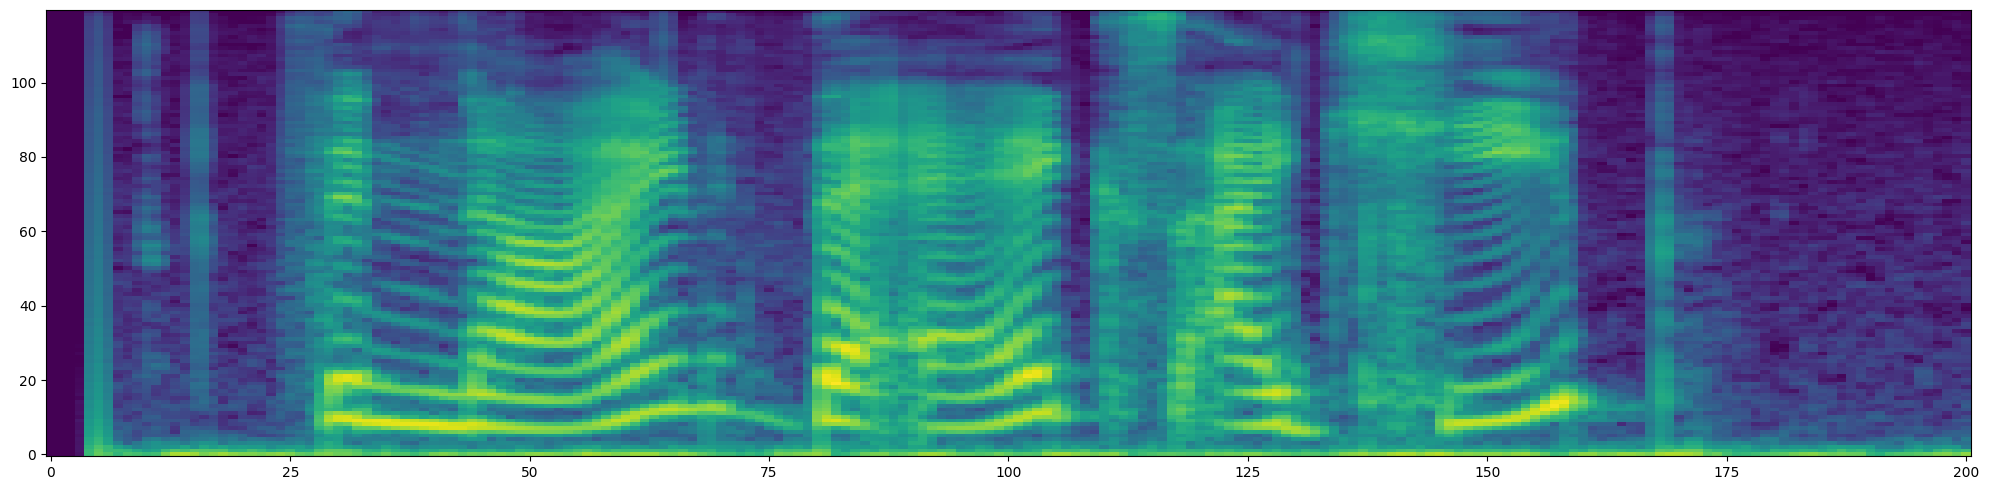

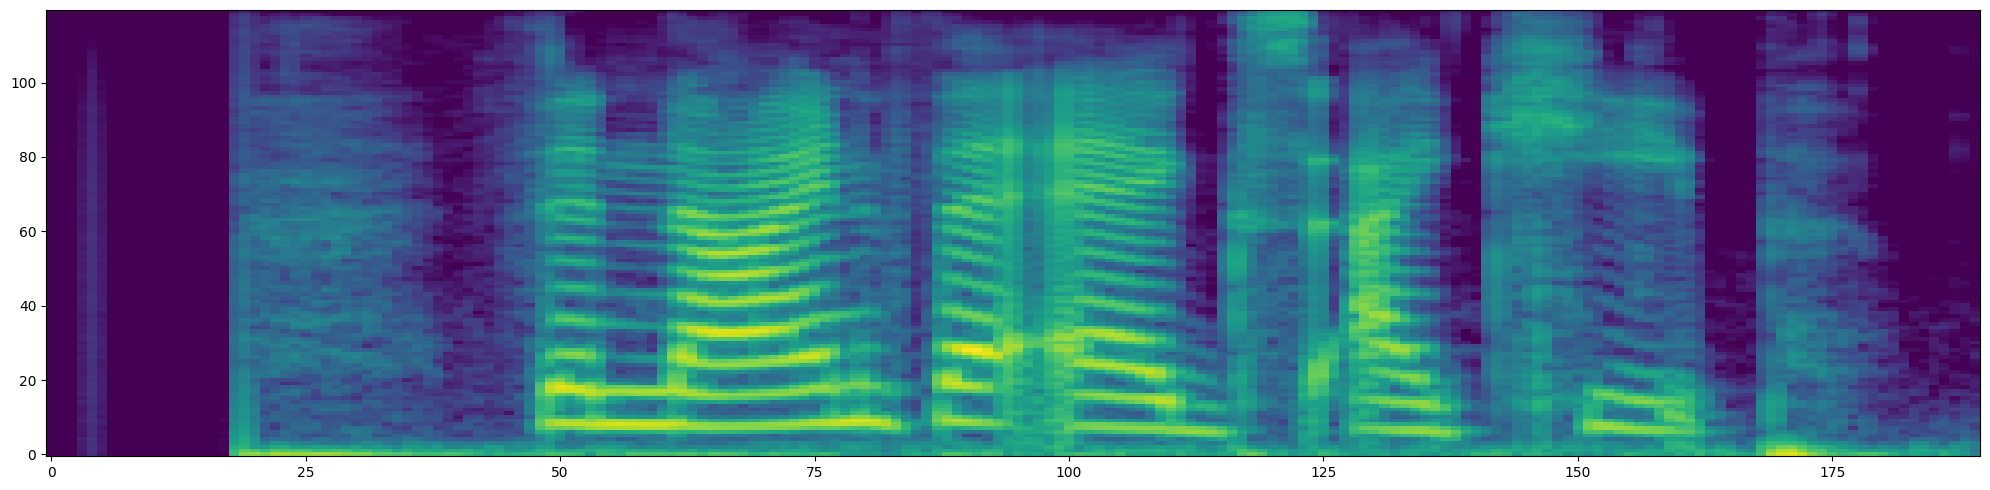

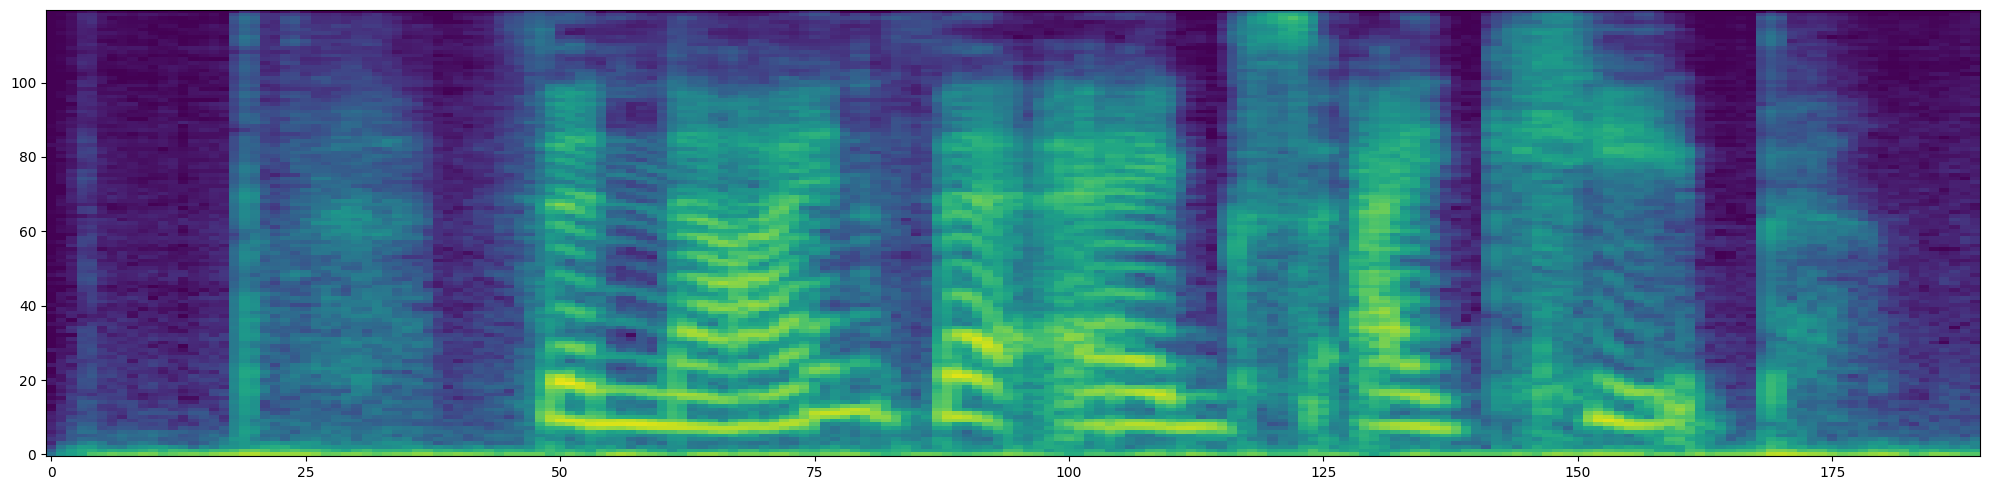

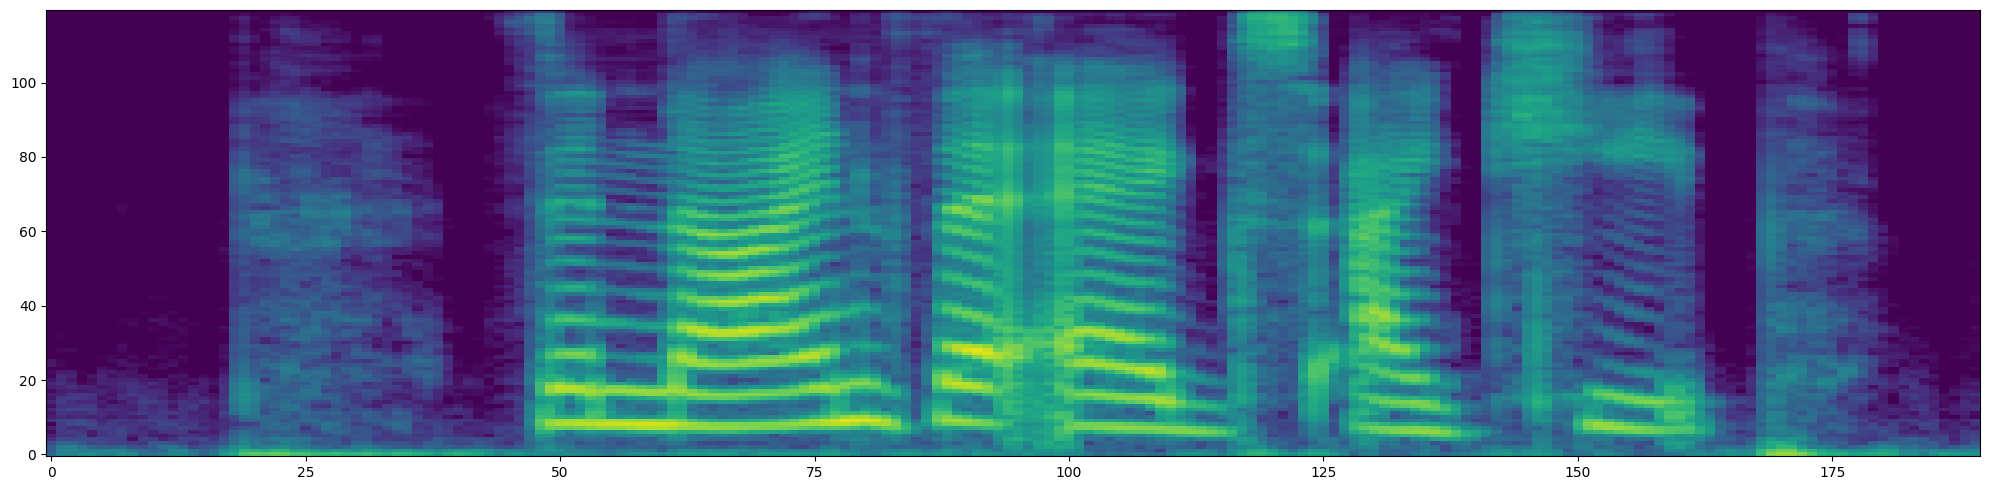

In [6]:
recon_wav = model.speech_convert(prosody_code, cotent_code, target_style)
e_recon_wav = model.decode(e_prosody_code, e_cotent_code, e_residual_code, e_spk_embs)
plot_debug(source_style)
plot_debug(source)
plot_debug(recon_wav)
plot_debug(e_recon_wav)

In [7]:
# start = 0
# end = 128
# for i in range(10):
#     f = i / 19.0
#     style = spk_embs
#     style[start:end] = spk_embs[start:end] * (1 - f) + target_style[start:end] * f
#     recon_wav = model.speech_convert(prosody_code, cotent_code, style)
#     plot_debug(recon_wav)

In [12]:
print(model.embeddings(e_prosody_code, e_cotent_code, e_residual_code))
print(model.embeddings(prosody_code, cotent_code, residual_code))
print(model.embeddings(prosody_code, cotent_code, residual_code) - model.embeddings(e_prosody_code, e_cotent_code, e_residual_code))
print((model.embeddings(prosody_code, cotent_code, residual_code) - model.embeddings(e_prosody_code, e_cotent_code, e_residual_code)).mean())

tensor([[[18.4588, 21.7959, 18.0839,  ..., 22.3203, 23.2319, 22.9672],
         [19.0324, 22.7275, 19.0017,  ..., 22.8019, 22.0753, 24.7532],
         [33.9511, 30.7063, 32.9199,  ..., 27.9687, 32.8036, 27.0321],
         ...,
         [20.8997, 24.1898, 19.8791,  ..., 23.1656, 23.4545, 25.9921],
         [20.4738, 19.9452, 19.4424,  ..., 23.8891, 23.2605, 24.2673],
         [19.6779, 21.5690, 20.0923,  ..., 23.7070, 23.4423, 23.6188]]])
tensor([[[21.4483, 20.2779, 22.8931,  ..., 22.9886, 21.1616, 20.0030],
         [21.8511, 20.6738, 20.7304,  ..., 25.8520, 21.8933, 21.3680],
         [29.2661, 29.5088, 27.7378,  ..., 22.3406, 23.6710, 25.8083],
         ...,
         [22.6400, 21.2787, 19.7645,  ..., 23.2583, 22.4288, 21.0530],
         [23.4216, 21.8290, 21.4301,  ..., 22.1482, 22.5204, 22.8005],
         [20.6989, 22.9904, 21.1896,  ..., 22.2026, 22.0280, 20.9123]]])
tensor([[[ 2.9895, -1.5180,  4.8092,  ...,  0.6683, -2.0702, -2.9642],
         [ 2.8187, -2.0536,  1.7288,  ...,  3